# Table of contents
### For the competition | https://www.kaggle.com/c/santander-value-prediction-challenge
   1. [Set up](#Set-up)
   2. [Data analysis](#Data-analysis) 
   3. [Feature selection](#Feature-selection)
   4. [Build model AUTOML](#Build-model-AUTOML)
   5. [Build model CatBoostRegressor](#Build-model-CatBoostRegressor)
   6. [Build model RandomForestRegressor](#Build-model-RandomForestRegressor)
   7. [Build model XGBRegressor](#Build-model-XGBRegressor)
   8. [Submission](#Submission)
   9. [Future direction](#Future-direction)

## Set up

In [3]:
import h2o
h2o.init(nthreads = -1, max_mem_size = 55)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/skye/anaconda3/envs/python36/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpn1euo1fk
  JVM stdout: /tmp/tmpn1euo1fk/h2o_skye_started_from_python.out
  JVM stderr: /tmp/tmpn1euo1fk/h2o_skye_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,1 month and 7 days
H2O cluster name:,H2O_from_python_skye_6yka22
H2O cluster total nodes:,1
H2O cluster free memory:,48.89 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [4]:
import pandas as pd
import zipfile
import gc
from sklearn.metrics import mean_squared_log_error,mean_squared_error
#settings
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 200)
pd.set_option('display.expand_frame_repr', False)

In [5]:
train = pd.read_csv(zipfile.ZipFile('train.csv.zip').open('train.csv'))
test = pd.read_csv(zipfile.ZipFile('test.csv.zip').open('test.csv'))

In [6]:
#Move id and target out of main train
train_id = train['ID']
train_target = train['target']

del train['ID'], train['target']

In [7]:
test_id = test['ID']
del test['ID']

In [8]:
gc.collect()

21

In [9]:
model_summary = pd.DataFrame()

## Data analysis

In [10]:
print("train shape: ", train.shape)
print("test shape: ", test.shape)

train shape:  (4459, 4991)
test shape:  (49342, 4991)


In [11]:
# Missing data
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [12]:
missing_stats = missing_values_table(train)
missing_stats = missing_stats.reset_index()
missing_stats.head()

Your selected dataframe has 4991 columns.
There are 0 columns that have missing values.


,index,Missing Values,% of Total Values


In [13]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/skye/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


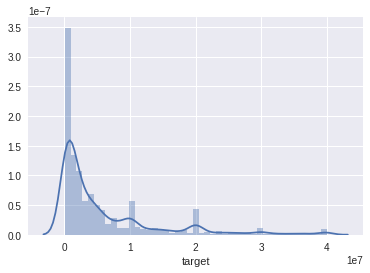

In [14]:
sns.distplot(train_target)

/home/skye/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


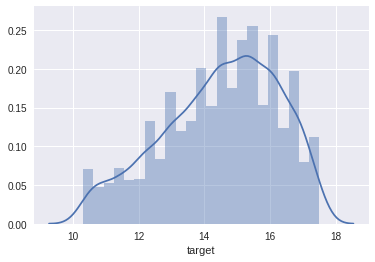

In [15]:
sns.distplot(np.log(train_target) )

In [16]:
# Remove variables with no variance
from sklearn.feature_selection import VarianceThreshold
def variance_threshold_selector(data, threshold=None):
    if threshold == None:
        selector = VarianceThreshold()
    else:
        selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data.columns[selector.get_support(indices=True)], data[data.columns[selector.get_support(indices=True)]]

In [17]:
variance_cols, train = variance_threshold_selector(train)

In [18]:
train.shape

(4459, 4735)

In [18]:
train.describe().T.sort_values(by=['min', 'max'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
2b85882ad,4459.0,1.350759e+06,6.970446e+07,0.0,0.0,0.0,0.00,4.652000e+09
07cb6041d,4459.0,1.314797e+06,6.970193e+07,0.0,0.0,0.0,0.00,4.652000e+09
ede70bfea,4459.0,1.251997e+06,6.968794e+07,0.0,0.0,0.0,0.00,4.652000e+09
3be4dad48,4459.0,1.353815e+06,6.972647e+07,0.0,0.0,0.0,0.00,4.652000e+09
625525b5d,4459.0,1.350174e+06,6.971055e+07,0.0,0.0,0.0,0.00,4.652000e+09
df6a71cc7,4459.0,1.294199e+06,6.969407e+07,0.0,0.0,0.0,0.00,4.652000e+09
3d23e8abd,4459.0,1.332383e+06,6.972387e+07,0.0,0.0,0.0,0.00,4.652000e+09
4ceef6dbd,4459.0,1.315575e+06,6.970035e+07,0.0,0.0,0.0,0.00,4.652000e+09
9fa984817,4459.0,1.316758e+06,6.970706e+07,0.0,0.0,0.0,0.00,4.652000e+09
f1c272f04,4459.0,1.433172e+06,3.715103e+07,0.0,0.0,0.0,0.00,2.243000e+09


In [19]:
from sklearn.preprocessing import MinMaxScaler
mm_sc = MinMaxScaler(feature_range=(0,1))
train_mm_sc = mm_sc.fit_transform(train[variance_cols])
test_mm_sc = mm_sc.transform(test[variance_cols])

In [20]:
train_target_log = np.log(train_target)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_mm_sc, train_target_log, 
                                                  test_size=0.15, random_state=0)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(test_mm_sc.shape)

(3790, 4735) (3790,)
(669, 4735) (669,)
(49342, 4735)


## Feature selection

In [22]:
X_train_h2o = h2o.H2OFrame(X_train)
X_val_h2o = h2o.H2OFrame(X_val)
X_test_h2o = h2o.H2OFrame(test_mm_sc)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
print(X_train_h2o.shape)
print(X_val_h2o.shape)
print(X_test_h2o.shape)

(3790, 4735)
(669, 4735)
(49342, 4735)


In [24]:
y_train_h2o = h2o.H2OFrame(pd.DataFrame(y_train) )
y_val_h2o = h2o.H2OFrame( pd.DataFrame(y_val) )

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [25]:
print(y_train_h2o.shape)
print(y_val_h2o.shape)

(3790, 1)
(669, 1)


In [26]:
train_frame = h2o.H2OFrame.cbind(X_train_h2o, y_train_h2o)
print(train_frame.shape)
validation_frame = h2o.H2OFrame.cbind(X_val_h2o, y_val_h2o)
print(validation_frame.shape)

(3790, 4736)
(669, 4736)


In [27]:
print(X_test_h2o.shape)

(49342, 4735)


In [28]:
X_cols = X_train_h2o.col_names
y_col = y_train_h2o.col_names[0]

In [29]:
h2o.ls()

,key
0,Key_Frame__upload_886ad9b89fa4397c83d04cb958a9...
1,Key_Frame__upload_9ae247d8cc2b50dc8267b0064000...
2,Key_Frame__upload_9c1263b5a970f760b953692091e9...
3,Key_Frame__upload_9c36ac78f291bc2cec3b9347909e...
4,Key_Frame__upload_bc587df10ba5568f7a16792fc510...


## Build model AUTOML

In [30]:
from h2o.automl import H2OAutoML

In [31]:
aml = H2OAutoML(max_runtime_secs = 4000,
                seed=111)

In [32]:
aml.train(x = X_cols, 
          y = y_col, 
          training_frame = train_frame,
         validation_frame = validation_frame)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [33]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mae,rmsle
StackedEnsemble_AllModels_0_AutoML_20180701_162645,2.23457,1.49485,1.18808,0.100393
StackedEnsemble_BestOfFamily_0_AutoML_20180701_162645,2.26711,1.50569,1.19925,0.101104
GBM_grid_0_AutoML_20180701_162645_model_9,2.3069,1.51885,1.21933,0.102188
GBM_grid_0_AutoML_20180701_162645_model_4,2.30892,1.51951,1.21457,0.102198
GBM_grid_0_AutoML_20180701_162645_model_3,2.3095,1.51971,1.21405,0.102067
GBM_grid_0_AutoML_20180701_162645_model_2,2.31491,1.52148,1.21654,0.102203
GBM_grid_0_AutoML_20180701_162645_model_1,2.32022,1.52323,1.21991,0.102397
GBM_grid_0_AutoML_20180701_162645_model_0,2.34552,1.53151,1.23043,0.103009
XRT_0_AutoML_20180701_162645,2.35219,1.53368,1.22923,0.102888
DRF_0_AutoML_20180701_162645,2.45664,1.56737,1.25516,0.10543


## Submission

In [35]:
pred = aml.predict(X_test_h2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [57]:
sub_pred = pred.as_data_frame()

In [61]:
submission = None
submission = pd.DataFrame({'ID': test_id, 
                           'target': np.expm1(sub_pred.iloc[:,0])})

In [62]:
submission.head()

,ID,target
0,000137c73,1.363630e+06
1,00021489f,1.387348e+06
2,0004d7953,2.032752e+06
3,00056a333,4.956640e+06
4,00056d8eb,1.387348e+06


In [63]:
submission.to_csv('auto_ml_submission.csv', 
                  index=False)